In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
from datetime import datetime,timedelta

### background map

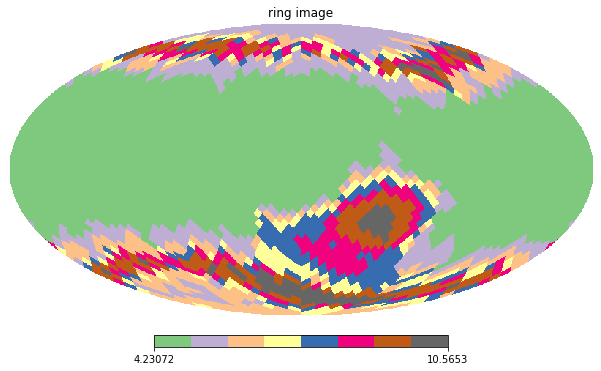

In [5]:
import sys
#sys.path.append("/home/limu/Code/Monty/")
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
back=np.loadtxt("/home/limu/Documents/Space/GRBalpha/pict/healpix-background_4.txt").T
hp.mollview(np.log(back[-1]),title="ring image",nest=True,cmap=pl.cm.Accent)

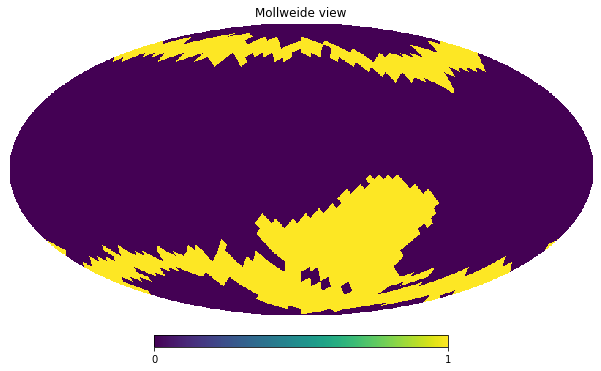

In [6]:
hp.mollview(np.log(back[-1])>7,nest=True)

In [43]:
px=hp.ang2pix(16,np.deg2rad(10),np.deg2rad(40),nest=True)
max(back[3])

38767.3

In [46]:
#TLE from /space/vzlusat2/processed_data/IDL/Data_firmware_initial/IDL_code/pypredict/20220314/tle.txt
pars=['latitude','longitude','elevation','azimuth','epoch']
expars=lambda v:[v[p] for p in pars]

import predict
tle=open("/home/limu/Space/pos/tle_vzlu_220314.txt").read().strip()
now=datetime.now()
qth_kos=[48.7408, -21.2284, 380]
vpass=np.array([expars(predict.observe(tle,qth_kos,(now+timedelta(0,20*i)).timestamp())) for i in range(1000)])

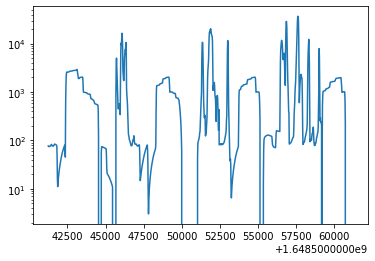

In [81]:
#pixs=[hp.ang2pix(16,np.deg2rad(p[1]),np.deg2rad(p[0]),nest=True) for p in vpass]
vals=[hp.pixelfunc.get_interp_val(back,p[1],p[0],nest=True,lonlat=True) for p in vpass]
#vals=[back[3][p] for p in pixs]
pl.semilogy(vpass[:,-1],vals)

In [141]:
np.log10(max(x)**2)

15.111431211007195

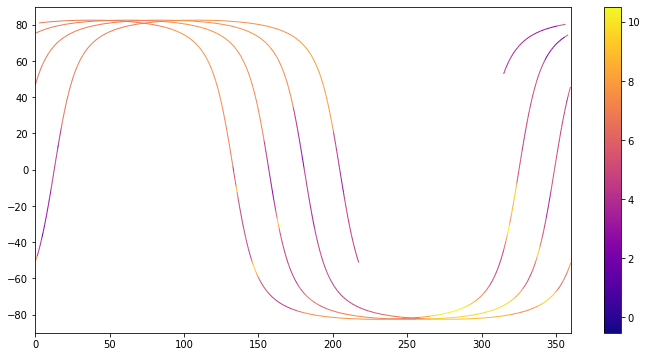

In [134]:
def plotcolor(x,y,dydx,fig=None,lims=[],maxseg=1e4):
    from matplotlib.collections import LineCollection
    from matplotlib.colors import ListedColormap, BoundaryNorm
    if fig==None: 
        fig=pl.figure(figsize=(12,6))
        fig.gca()
    points = np.array([x,y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    zz=np.array([sum((s[1]-s[0])**2) for s in segments])
    segments=[segments[i] for i in np.where(zz<maxseg)[0]]
    dydx=np.concatenate([dydx[:-1][zz<maxseg],dydx[-1:]])
    norm = pl.Normalize(dydx.min(), dydx.max())
    #lc = LineCollection(segments, cmap='viridis', norm=None)
    lc = LineCollection(segments, cmap='plasma', norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(1)
    line = fig.axes[0].add_collection(lc)
    fig.colorbar(line, ax=fig.axes[0])
    if len(lims)>0:
        fig.axes[0].set_xlim(0,360)
        fig.axes[0].set_ylim(-90,90)
        pl.show()
plotcolor(vpass[:,1],vpass[:,0],np.log(np.abs(vals)),lims=[360,90])

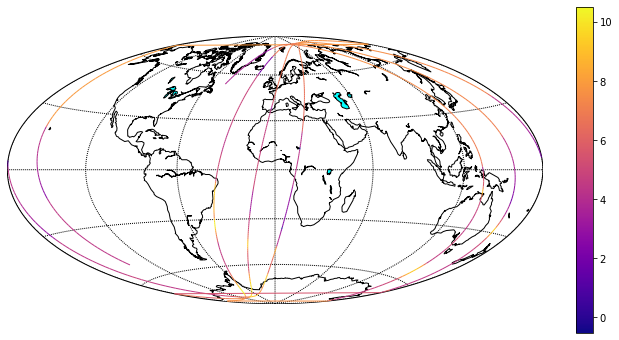

In [142]:
from mpl_toolkits.basemap import Basemap
fig=pl.figure(figsize=(12,6))
m = Basemap(projection='hammer',lon_0=0,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))

ok=m.fillcontinents(color='white',lake_color='aqua')
x,y=m(vpass[:,1],vpass[:,0])
#m.plot(x,y,'r')#c=np.log(vals))
plotcolor(x,y,np.log(np.abs(vals)),fig=fig,maxseg=1e15)

### predict GTI for observations

In [118]:
from scipy import ndimage as nd
sec,nsec=nd.label(np.array(vals)>100)

In [122]:
t0=vpass[:,-1][0]
time=vpass[:,-1]-t0
tsec=np.array([time[sec==i+1][[0,-1]] for i in range(nsec)])
dt=tsec[:,1]-tsec[:,0]
tsec[dt>100]

array([[ 1140.00000048,  3300.00000024],
       [ 4440.        ,  5340.00000024],
       [ 7080.00000024,  8740.        ],
       [ 9880.00000024, 11200.00000024],
       [11580.00000024, 11880.00000024],
       [12500.00000024, 13900.00000024],
       [14180.00000024, 14680.00000024],
       [14940.00000048, 15800.00000024],
       [16000.00000024, 16700.00000048],
       [16840.        , 17160.        ],
       [17260.00000024, 17420.00000024],
       [17600.00000024, 17940.        ],
       [18000.00000024, 19500.00000024]])

In [124]:
sum(dt<100)

2

### transit times

In [110]:
trans=predict.transits(tle,qth_kos,now.timestamp(),(now+timedelta(0,100000)).timestamp())
trans=[t for t in trans if t.peak()['elevation']>10]

In [111]:
pairs=[[t.above(0.5).duration(),t.peak()['elevation']] for t in trans]
pairs

[[703.8600075244904, 63.92141751924251],
 [583.6850008964539, 14.247157196685906],
 [687.2700023651123, 54.558875439714676],
 [585.9018261432648, 13.969165430860656],
 [698.3006672859192, 48.60737101878775],
 [612.9544501304626, 17.55137030269617]]

In [112]:
[[datetime.fromtimestamp(tx).isoformat()[:19].replace('T',' ') for tx in [t.start,t.peak()['epoch'],t.end]] for t in trans]

[['2022-03-29 10:49:39', '2022-03-29 10:55:39', '2022-03-29 11:01:39'],
 ['2022-03-29 12:24:32', '2022-03-29 12:29:33', '2022-03-29 12:34:34'],
 ['2022-03-29 21:35:31', '2022-03-29 21:41:19', '2022-03-29 21:47:17'],
 ['2022-03-29 23:11:02', '2022-03-29 23:16:02', '2022-03-29 23:21:07'],
 ['2022-03-30 10:39:25', '2022-03-30 10:45:23', '2022-03-30 10:51:20'],
 ['2022-03-30 12:14:09', '2022-03-30 12:19:24', '2022-03-30 12:24:45']]